In [1]:
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torchvision
from torchvision import transforms as T
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
import warnings

In [2]:
import os
from PIL import Image

In [3]:
images = sorted(os.listdir(r"C:\Users\laxmi\OneDrive\Desktop\Illegal_construction_detection\New folder1"))
masks = sorted(os.listdir(r"C:\Users\laxmi\OneDrive\Desktop\Illegal_construction_detection\New folder1_mask"))

In [4]:
images[:5]

['20241204_023216.jpg',
 '20241204_023243.jpg',
 '20241210_210624.jpg',
 '20241210_210638.jpg',
 '20241210_210652.jpg']

In [5]:
masks[:5]

['20241204_023216_mask.png',
 '20241204_023243_mask.png',
 '20241210_210624_mask.png',
 '20241210_210638_mask.png',
 '20241210_210652_mask.png']

In [6]:
idx = 0
img = Image.open(r"C:\Users\laxmi\OneDrive\Desktop\Illegal_construction_detection\New folder1\\" + images[idx]).convert("RGB")
mask = Image.open(r"C:\Users\laxmi\OneDrive\Desktop\Illegal_construction_detection\New folder1_mask\\" + masks[idx])

In [7]:
print(r"C:\Users\laxmi\OneDrive\Desktop\Illegal_construction_detection\New folder1_mask\\" + masks[idx])

C:\Users\laxmi\OneDrive\Desktop\model_scratch\data_to_be_mask\\20241204_023216_mask.png


In [ ]:
img

In [9]:
import numpy as np

In [10]:
x = np.unique(mask)

In [11]:
x

array([  0, 255], dtype=uint8)

In [ ]:
Image.fromarray(np.array(mask) == 255)

In [13]:
class CustDat(torch.utils.data.Dataset):
    def __init__(self , images , masks):
        self.imgs = images
        self.masks = masks

    def __getitem__(self, idx):
      img = Image.open(r"C:\Users\laxmi\OneDrive\Desktop\Illegal_construction_detection\New folder1\\" + self.imgs[idx]).convert("RGB")
      mask = Image.open(r"C:\Users\laxmi\OneDrive\Desktop\Illegal_construction_detection\New folder1_mask\\" + self.masks[idx])
      mask = np.array(mask)

      # Binary mask logic
      obj_ids = np.unique(mask)  # [0, 255]
      obj_ids = obj_ids[1:]  # Remove the background (0)
      num_objs = len(obj_ids)  # In this case, num_objs = 1 since obj_ids = [255]

      # Create masks
      masks = (mask == obj_ids[:, None, None])  # Shape: (num_objs, H, W)

      # Bounding boxes
      boxes = []
      for i in range(num_objs):
          pos = np.where(masks[i])
          if pos[0].size == 0 or pos[1].size == 0:
              # Handle empty mask
              continue
          xmin = np.min(pos[1])
          xmax = np.max(pos[1])
          ymin = np.min(pos[0])
          ymax = np.max(pos[0])
          boxes.append([xmin, ymin, xmax, ymax])
      boxes = torch.as_tensor(boxes, dtype=torch.float32)

      # Labels and masks
      labels = torch.ones((num_objs,), dtype=torch.int64)  # All objects have label 1
      masks = torch.as_tensor(masks, dtype=torch.uint8)

      # Prepare target dictionary
      target = {
          "boxes": boxes,
          "labels": labels,
          "masks": masks
      }
      return T.ToTensor()(img), target


    def __len__(self):
        return len(self.imgs)

In [14]:

model = torchvision.models.detection.maskrcnn_resnet50_fpn()
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features , 2)
in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
hidden_layer = 256
model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask , hidden_layer , 2)

In [17]:
transform = T.ToTensor()

In [18]:
def custom_collate(data):
  return data

In [16]:
# images = sorted(os.listdir(r"C:\Users\laxmi\OneDrive\Desktop\model_scratch\train"))
# masks = sorted(os.listdir(r"C:\Users\laxmi\OneDrive\Desktop\model_scratch\sih6"))
# num = int(0.9 * len(images))
# num = num if num % 2 == 0 else num + 1
# train_imgs_inds = np.random.choice(range(len(images)) , num , replace = False)
# val_imgs_inds = np.setdiff1d(range(len(images)) , train_imgs_inds)
# train_imgs = np.array(images)[train_imgs_inds]
# val_imgs = np.array(images)[val_imgs_inds]
# train_masks = np.array(masks)[train_imgs_inds]
# val_masks = np.array(masks)[val_imgs_inds]

In [17]:
# from torch.utils.data import Dataset
# from PIL import Image
# import os

# class CustomSegmentationDataset(Dataset):
#     def __init__(self, img_dir, mask_dir, transform=None):
#         """
#         Args:
#         - img_dir (str): Directory with images
#         - mask_dir (str): Directory with masks
#         - transform (callable, optional): Optional transform to be applied on a sample
#         """
#         self.img_dir = img_dir
#         self.mask_dir = mask_dir
        
#         # Get image and mask filenames
#         self.imgs = [f for f in os.listdir(img_dir) if f.endswith(('.jpg', '.png', '.jpeg'))]
#         self.masks = [f.replace('.jpg', '_mask.png').replace('.jpeg', '_mask.png') 
#                       for f in self.imgs]
        
#         # Verify all masks exist
#         self.masks = [m for m in self.masks if os.path.exists(os.path.join(mask_dir, m))]
        
#         self.transform = transform

#     def __len__(self):
#         return len(self.imgs)

#     def __getitem__(self, idx):
#         # Load image
#         img_path = os.path.join(self.img_dir, self.imgs[idx])
#         img = Image.open(img_path).convert("RGB")
        
#         # Load mask
#         mask_filename = self.imgs[idx].replace('.jpg', '_mask.png').replace('.jpeg', '_mask.png')
#         mask_path = os.path.join(self.mask_dir, mask_filename)
#         mask = Image.open(mask_path)
        
#         # Apply transforms if specified
#         if self.transform:
#             img, mask = self.transform((img, mask))
        
#         return img, mask

# # Example usage
# if __name__ == "__main__":
#     dataset = CustomSegmentationDataset(
#         img_dir=r"C:\Users\laxmi\OneDrive\Desktop\model_scratch\train",
#         mask_dir=r"C:\Users\laxmi\OneDrive\Desktop\model_scratch\sih6"
#     )
    
#     # Print dataset size and test loading an item
#     print(f"Dataset size: {len(dataset)}")
#     img, mask = dataset[0]
#     print(f"Image shape: {img.size}")
#     print(f"Mask shape: {mask.size}")

In [19]:
images =sorted(os.listdir(r"C:\Users\laxmi\OneDrive\Desktop\Illegal_construction_detection\New folder1"))
masks = sorted(os.listdir(r"C:\Users\laxmi\OneDrive\Desktop\Illegal_construction_detection\New folder1_mask"))

# Ensure that the number of chosen images for training does not exceed the number of masks
num = int(0.9 * min(len(images), len(masks)))
num = num if num % 2 == 0 else num + 1

# Generate indices for training images, considering the length of the masks
train_imgs_inds = np.random.choice(range(len(masks)), num, replace=False)

# Get indices for validation images
val_imgs_inds = np.setdiff1d(range(len(masks)), train_imgs_inds)

# Select images and masks for training and validation based on the adjusted indices
train_imgs = np.array(images)[train_imgs_inds]
val_imgs = np.array(images)[val_imgs_inds]
train_masks = np.array(masks)[train_imgs_inds]
val_masks = np.array(masks)[val_imgs_inds]

In [20]:
train_imgs.shape

(30,)

In [20]:
# train_dl = torch.utils.data.DataLoader(CustDat(train_imgs , train_masks) ,
#                                  batch_size = 2 ,
#                                  shuffle = True ,
#                                  collate_fn = custom_collate ,
#                                  num_workers = 1 ,
#                                  pin_memory = True if torch.cuda.is_available() else False)
# val_dl = torch.utils.data.DataLoader(CustDat(val_imgs , val_masks) ,
#                                  batch_size = 2 ,
#                                  shuffle = True ,
#                                  collate_fn = custom_collate ,
#                                  num_workers = 1 ,
#                                  pin_memory = True if torch.cuda.is_available() else False)

In [21]:
train_dl = torch.utils.data.DataLoader(
    CustDat(train_imgs, train_masks),
    batch_size=2,
    shuffle=True,
    collate_fn=custom_collate,
    num_workers=0,  # Changed from 1
    pin_memory=torch.cuda.is_available()
)

val_dl = torch.utils.data.DataLoader(
    CustDat(val_imgs, val_masks),
    batch_size=2,
    shuffle=True,
    collate_fn=custom_collate,
    num_workers=0,  # Changed from 1
    pin_memory=torch.cuda.is_available()
)

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [23]:
model.to(device)

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu):

In [24]:
params = [p for p in model.parameters() if p.requires_grad]

In [25]:
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

below there are two ways of training use 2nd if 1st doesnt work

In [3]:
# all_train_losses = []
# all_val_losses = []
# flag = False
# for epoch in range(30):
#     train_epoch_loss = 0
#     val_epoch_loss = 0
#     model.train()
#     for i , dt in enumerate(train_dl):
#         imgs = [dt[0][0].to(device) , dt[1][0].to(device)]
#         targ = [dt[0][1] , dt[1][1]]
#         targets = [{k: v.to(device) for k, v in t.items()} for t in targ]
#         loss = model(imgs , targets)
#         if not flag:
#             print(loss)
#             flag = True
#         losses = sum([l for l in loss.values()])
#         train_epoch_loss += losses.cpu().detach().numpy()
#         optimizer.zero_grad()
#         losses.backward()
#         optimizer.step()
#     all_train_losses.append(train_epoch_loss)
#     with torch.no_grad():
#         for j , dt in enumerate(val_dl):
#             imgs = [dt[0][0].to(device) , dt[1][0].to(device)]
#             targ = [dt[0][1] , dt[1][1]]
#             targets = [{k: v.to(device) for k, v in t.items()} for t in targ]
#             loss = model(imgs , targets)
#             losses = sum([l for l in loss.values()])
#             val_epoch_loss += losses.cpu().detach().numpy()
#         all_val_losses.append(val_epoch_loss)
#     print(epoch , "  " , train_epoch_loss , "  " , val_epoch_loss)

In [ ]:
all_train_losses = []
all_val_losses = []
flag = False
for epoch in range(30):
    train_epoch_loss = 0
    val_epoch_loss = 0
    model.train()
    for i , dt in enumerate(train_dl):
        imgs = [dt[0][0].to(device) , dt[1][0].to(device)]
        targ = [dt[0][1] , dt[1][1]]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targ]
        loss = model(imgs , targets)
        if not flag:
            print(loss)
            flag = True
        losses = sum([l for l in loss.values()])
        train_epoch_loss += losses.cpu().detach().numpy()
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
    all_train_losses.append(train_epoch_loss)
    with torch.no_grad():
        for j , dt in enumerate(val_dl):
            # Check if the batch has the expected structure
            if len(dt) >= 2 and len(dt[0]) >= 1 and len(dt[1]) >= 1:
                imgs = [dt[0][0].to(device) , dt[1][0].to(device)]
                targ = [dt[0][1] , dt[1][1]]
                targets = [{k: v.to(device) for k, v in t.items()} for t in targ]
                loss = model(imgs , targets)
                losses = sum([l for l in loss.values()])
                val_epoch_loss += losses.cpu().detach().numpy()
            else:
                # Handle the case where the batch has unexpected structure or is empty
                print(f"Skipping batch {j} due to unexpected structure or empty batch.")
        all_val_losses.append(val_epoch_loss)
    print(epoch , "  " , train_epoch_loss , "  " , val_epoch_loss)

{'loss_classifier': tensor(0.0493, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1108, device='cuda:0', grad_fn=<DivBackward0>), 'loss_mask': tensor(0.6074, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_objectness': tensor(0.2098, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0048, device='cuda:0', grad_fn=<DivBackward0>)}
Skipping batch 1 due to unexpected structure or empty batch.
0    12.596248    0.61946803
Skipping batch 1 due to unexpected structure or empty batch.
1    11.652695    0.69036925
Skipping batch 1 due to unexpected structure or empty batch.
2    10.6485405    0.6180041
Skipping batch 1 due to unexpected structure or empty batch.
3    10.942233    0.6952493
Skipping batch 1 due to unexpected structure or empty batch.
4    10.510788    0.637616
Skipping batch 1 due to unexpected structure or empty batch.
5    10.294669    0.5852389
Skipping batch 1 due to

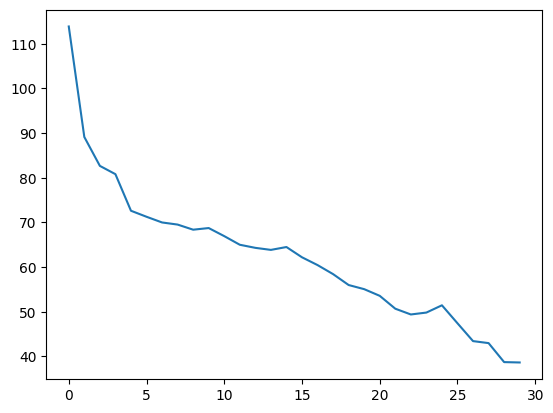

In [27]:
plt.plot(all_train_losses)

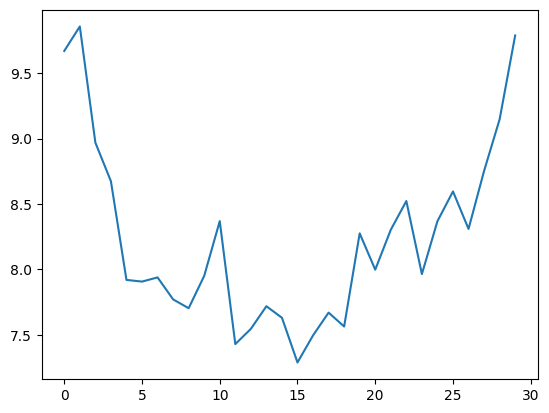

In [28]:
plt.plot(all_val_losses)

In [29]:
# !wget https://cdn.pixabay.com/photo/2018/09/18/21/08/couple-3687274_960_720.jpg

'wget' is not recognized as an internal or external command,
operable program or batch file.


In [30]:
# import requests

# url = "https://cdn.pixabay.com/photo/2018/09/18/21/08/couple-3687274_960_720.jpg"
# response = requests.get(url)
# with open("couple_image.jpg", "wb") as file:
#     file.write(response.content)

ModuleNotFoundError: No module named 'requests'

Do prediction here and save model weights

In [ ]:
model.eval()
img = img = Image.open(r"path to image for prediction").convert("RGB")

transform = T.ToTensor()
ig = transform(img)
with torch.no_grad():
    pred = model([ig.to(device)])

In [39]:
import torch

# Assuming model is your PyTorch Mask R-CNN model
torch.save(model.state_dict(), "sih1_2_3_4_weights.pth")

In [40]:
# import torch
# import pickle
# from torchvision.models.detection import maskrcnn_resnet50_fpn
# from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
# from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

# # Define the model
# def get_model_instance():
#     model = maskrcnn_resnet50_fpn()

#     # Modify the box predictor
#     in_features = model.roi_heads.box_predictor.cls_score.in_features
#     model.roi_heads.box_predictor = FastRCNNPredictor(in_features, 2)

#     # Modify the mask predictor
#     in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
#     hidden_layer = 256
#     model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, 2)
    
#     return model

# # Create and save the model
# model = get_model_instance()

# # Save the model with pickle
# def save_model_pickle(model, filename):
#     with open(filename, 'wb') as file:
#         pickle.dump(model, file)
#     print(f"Model saved to {filename}")

# # Load the model
# def load_model_pickle(filename):
#     with open(filename, 'rb') as file:
#         model = pickle.load(file)
#     print(f"Model loaded from {filename}")
#     return model

# # Save the model
# save_model_pickle(model, "mask_rcnn_model.pkl")

# # Load the model
# loaded_model = load_model_pickle("mask_rcnn_model.pkl")

# # Check the loaded model
# print(loaded_model)


Model saved to mask_rcnn_model.pkl
Model loaded from mask_rcnn_model.pkl
MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=Fa

In [5]:
# import csv
# import random

# # Generate random numbers
# data = [[random.randint(1, 100)] for _ in range(10)]

# # Save to CSV
# file_path = "random_numbers.csv"
# with open(file_path, "w", newline="") as file:
#     writer = csv.writer(file)
#     writer.writerow(["Random Numbers"])  # Add header
#     writer.writerows(data)

# print(f"CSV file '{file_path}' created successfully!")

# # Confirm export


CSV file 'random_numbers.csv' created successfully!


In [10]:
# import pandas as pd
# k = pd.read_csv(file_path)

ModuleNotFoundError: No module named 'pandas'

In [11]:
# pip install pandas

   ---------------------------------------- 0.0/11.5 MB ? eta -:--:--
   -- ------------------------------------- 0.8/11.5 MB 5.6 MB/s eta 0:00:02
   -------- ------------------------------- 2.4/11.5 MB 6.4 MB/s eta 0:00:02
   ------------- -------------------------- 3.9/11.5 MB 6.9 MB/s eta 0:00:02
   -------------------- ------------------- 6.0/11.5 MB 7.5 MB/s eta 0:00:01
   --------------------------- ------------ 7.9/11.5 MB 7.6 MB/s eta 0:00:01
   ------------------------------- -------- 9.2/11.5 MB 7.6 MB/s eta 0:00:01
   ------------------------------------- -- 10.7/11.5 MB 7.5 MB/s eta 0:00:01
   ---------------------------------------  11.3/11.5 MB 7.3 MB/s eta 0:00:01
   ---------------------------------------- 11.5/11.5 MB 6.7 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.
